In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [21]:
def plot_series(time, series, format="-", start=0, end=None):
    
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


def extract_last_4_chars(value):
    return value[-4:]


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [2]:
raw_data = pd.read_csv("GDP_Dataset.csv")

raw_data['date'] = raw_data['date'].apply(extract_last_4_chars)

raw_data["date"] = raw_data["date"].astype(int)

raw_data.replace(np.nan, 0)

print(raw_data)

    date         GDP   Per Capita   Growthannualchange
0   1960    3.749265      81.5869                  NaN
1   1961    4.118648      87.5174               5.9873
2   1962    4.310164      89.4933               4.4829
3   1963    4.630827      93.8839               8.6888
4   1964    5.204956     102.9612               7.5698
..   ...         ...          ...                  ...
58  2018  356.128225    1620.7429               6.1517
59  2019  320.909489    1437.1659               2.4976
60  2020  300.425667    1322.3150              -1.2741
61  2021  348.262545    1505.0102               6.4871
62  2022  414.885900    1579.2250               4.9312

[63 rows x 4 columns]


In [3]:
series = raw_data[" GDP"].values
time = raw_data["date"].values

In [4]:
split_time = 56

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [42]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [44]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [59]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 500.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

In [60]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
2/2 [==============================] - 7s 39ms/step - loss: 139.0506 - lr: 1.0000e-08
Epoch 2/100
2/2 [==============================] - 0s 19ms/step - loss: 138.8224 - lr: 1.1220e-08
Epoch 3/100
2/2 [==============================] - 0s 19ms/step - loss: 138.3861 - lr: 1.2589e-08
Epoch 4/100
2/2 [==============================] - 0s 19ms/step - loss: 137.6702 - lr: 1.4125e-08
Epoch 5/100
2/2 [==============================] - 0s 17ms/step - loss: 136.7468 - lr: 1.5849e-08
Epoch 6/100
2/2 [==============================] - 0s 18ms/step - loss: 135.4538 - lr: 1.7783e-08
Epoch 7/100
2/2 [==============================] - 0s 19ms/step - loss: 134.0001 - lr: 1.9953e-08
Epoch 8/100
2/2 [==============================] - 0s 18ms/step - loss: 132.2103 - lr: 2.2387e-08
Epoch 9/100
2/2 [==============================] - 0s 17ms/step - loss: 130.0722 - lr: 2.5119e-08
Epoch 10/100
2/2 [==============================] - 0s 17ms/step - loss: 127.7282 - lr: 2.8184e-08
Epoch 11/100
2/2 [=

(1e-08, 0.001, 0.0, 30.0)

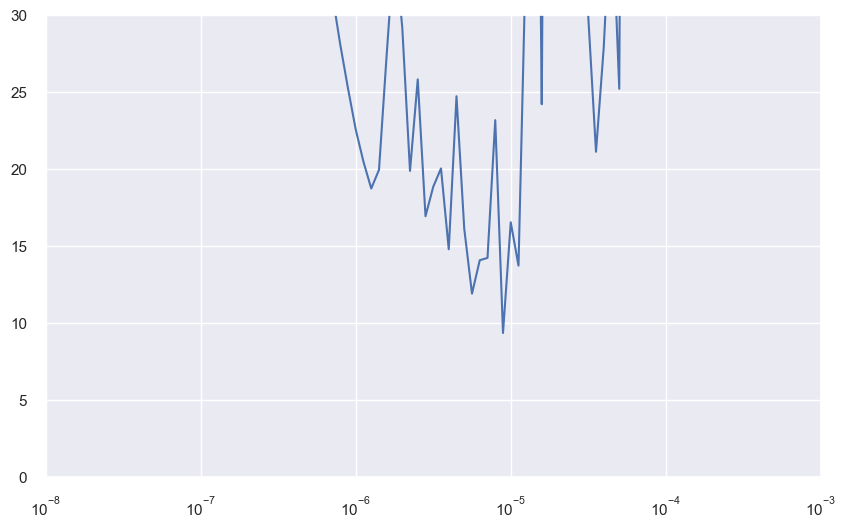

In [61]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

In [71]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])

learning_rate = 9e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=300, validation_data=val_set)

Epoch 1/300
2/2 [==============================] - 4s 734ms/step - loss: 163.2857 - mae: 163.7857
Epoch 2/300
2/2 [==============================] - 0s 44ms/step - loss: 101.2496 - mae: 101.7496
Epoch 3/300
2/2 [==============================] - 0s 42ms/step - loss: 151.3408 - mae: 151.8408
Epoch 4/300
2/2 [==============================] - 0s 42ms/step - loss: 66.1117 - mae: 66.6117
Epoch 5/300
2/2 [==============================] - 0s 39ms/step - loss: 121.1558 - mae: 121.6558
Epoch 6/300
2/2 [==============================] - 0s 39ms/step - loss: 42.0629 - mae: 42.5623
Epoch 7/300
2/2 [==============================] - 0s 36ms/step - loss: 77.9582 - mae: 78.4522
Epoch 8/300
2/2 [==============================] - 0s 36ms/step - loss: 34.1019 - mae: 34.6019
Epoch 9/300
2/2 [==============================] - 0s 34ms/step - loss: 68.6771 - mae: 69.1771
Epoch 10/300
2/2 [==============================] - 0s 37ms/step - loss: 46.8413 - mae: 47.3413
Epoch 11/300
2/2 [======================

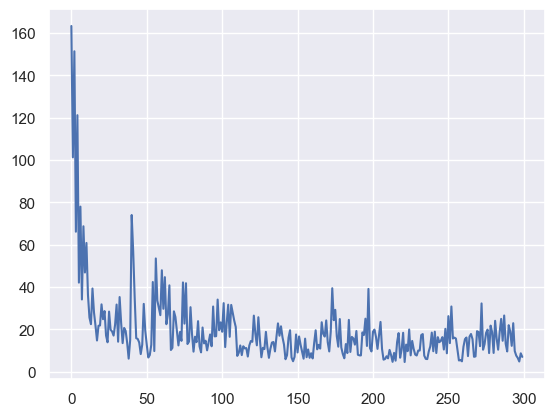

In [72]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [73]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)

    return forecast

1/1 [==============================] - 1s 1s/step


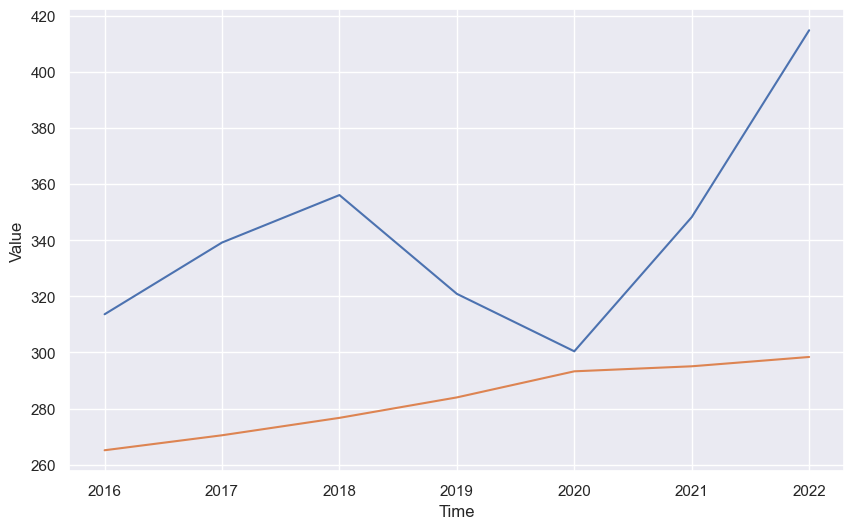

In [74]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

1/1 [==============================] - 0s 23ms/step


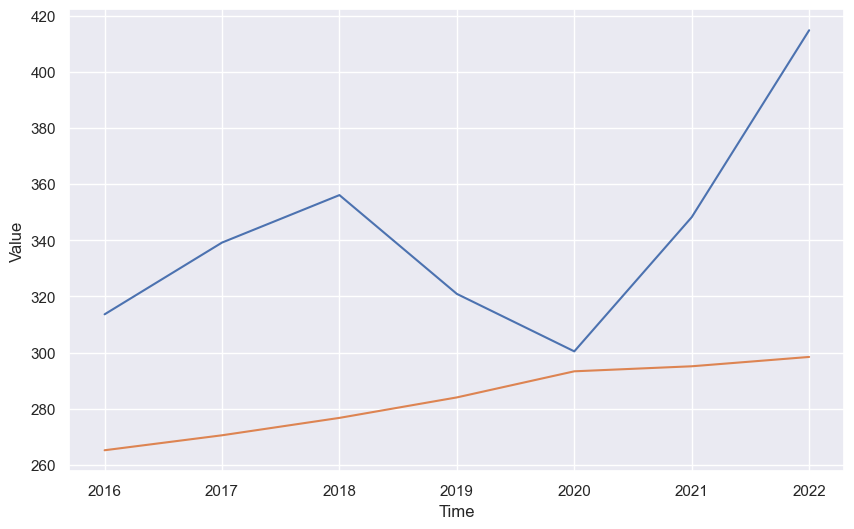

In [75]:
forecast = []
forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [76]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4452.7114
58.593697
